## Imports

In [1]:
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

from timm import create_model
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from sklearn.cluster import MiniBatchKMeans


/home/leo/anaconda3/envs/silkworm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Globals
Centralised configuration so it is easy to tweak hyper-parameters in one place

In [2]:
DATA_DIR = Path('./data/images')
MODEL_DIR = Path('./models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 512x512 crops → lower batch for 6 GB GPUs; feel free to raise if you have 32 GB
BATCH_SIZE  = 2
IMG_SIZE    = 512          # high-res to catch thin worms
NUM_EPOCHS  = 30
LEARNING_RATE = 1e-5
ACCUM_STEPS = 4             # keeps effective batch 8
NUM_WORKERS = os.cpu_count() // 2 or 2

NUM_CLUSTERS = 4            # background / leaf / worm
SEED = 14

torch.manual_seed(SEED)
np.random.seed(SEED)

## Utils
Re-usable helpers (metrics, schedulers, visualisation)

In [3]:
class Timer:
    """Simple context manager for timing code blocks"""
    def __enter__(self):
        self.start = datetime.now()
        return self
    def __exit__(self, *args):
        self.duration = datetime.now() - self.start

def cosine_decay(optimizer, epoch, total_epochs, base_lr):
    """Sets LR following a half-cosine schedule"""
    lr = 0.5 * base_lr * (1 + np.cos(np.pi * epoch / total_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def kmeans_labels(feats, k):
    """feats: (B, H, W, C) tensor on CUDA → returns (B, H, W) labels on CUDA"""
    B, H, W, C = feats.shape
    km = MiniBatchKMeans(k, n_init='auto', max_iter=30, batch_size=8192)
    lbl = []
    feats_np = feats.cpu().reshape(-1, C).numpy()
    km.fit(feats_np)
    pred = torch.from_numpy(km.labels_).to(feats.device)
    return pred.view(B, H, W)

## Data
Minimal custom dataset that serves single-image batches for unsupervised training

In [4]:
from torchvision.transforms import functional as TF
import random

class SilkwormDataset(Dataset):
    def __init__(self, root: Path):
        self.img_paths = sorted([p for p in root.iterdir() 
                                  if p.suffix.lower() in {'.jpg', '.png'}])
        self.resize_size = (IMG_SIZE, IMG_SIZE)

    def __len__(self): return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')

        # --- random zoom keeps thin worms detailed ---
        zoom_scale = random.uniform(0.8, 0.9)
        w, h = img.size
        nw, nh = int(w * zoom_scale), int(h * zoom_scale)
        l, t = (w - nw) // 2, (h - nh) // 2
        img = img.crop((l, t, l + nw, t + nh))
        img = TF.pad(img,
                     padding=(t, l, h - nh - t, w - nw - l),
                     fill=(128, 128, 128))

        # colour-shadow aug
        img = TF.adjust_contrast(img,    random.uniform(1.2, 1.5))
        img = TF.adjust_saturation(img,  random.uniform(1.2, 1.5))
        img = TF.adjust_brightness(img,  random.uniform(0.9, 1.1))
        img = TF.adjust_gamma(img,       random.uniform(0.9, 1.1))

        img = TF.resize(img, self.resize_size)
        ten = TF.to_tensor(img)
        ten = TF.normalize(ten, mean=[0.485, 0.456, 0.406],
                                std =[0.229, 0.224, 0.225])
        return ten

# Recreate dataloader
dataloader = DataLoader(
    SilkwormDataset(DATA_DIR),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)


## Network
Frozen DINO ViT backbone + lightweight UNet decoder

In [5]:
class HighResFPN(nn.Module):
    def __init__(self, in_ch: int, n_cls: int):
        super().__init__()
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(in_ch, 256, 2, stride=2), nn.ReLU(True),
            nn.Conv2d(256, 128, 3, padding=1),           nn.ReLU(True)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),    nn.ReLU(True),
            nn.Conv2d(64, 32, 3, padding=1),             nn.ReLU(True)
        )
        self.up3 = nn.Sequential(                             # extra stage for 1024 px
            nn.ConvTranspose2d(32, 16, 2, stride=2),    nn.ReLU(True),
            nn.Conv2d(16,  8, 3, padding=1),            nn.ReLU(True)
        )
        self.head = nn.Conv2d(8, n_cls, 1)

    def forward(self, x):
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        return self.head(x)

class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        # ViT-small, patch-8 DINO backbone
        self.backbone = create_model(
            "vit_small_patch8_224.dino", pretrained=True, num_classes=0)
        # allow arbitrary image size (avoids 224×224 assert)
        self.backbone.patch_embed.strict_img_size = False
        for p in self.backbone.parameters(): p.requires_grad = False
        self.decoder = HighResFPN(self.backbone.embed_dim, NUM_CLUSTERS)

    def forward(self, imgs):
        B = imgs.size(0)
        tok = self.backbone.patch_embed(imgs)           # (B, N, D) with N = (H/8)*(W/8)
        h = w = int(tok.size(1) ** 0.5)                 # for 1024 px ⇒ h=w=128
        feat = tok.permute(0, 2, 1).reshape(B, -1, h, w)
        return self.decoder(feat)                       # (B, C, 1024, 1024)


## Train
Generic training loop with mixed precision and runtime logging

In [6]:
# instantiate network, move it to GPU, and create optimizer/criterion
model = SegModel().to(DEVICE)

scaler     = GradScaler()
optimizer  = torch.optim.AdamW(model.decoder.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion  = nn.CrossEntropyLoss()

with Timer() as t_total:
    global_step = 0
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        epoch_loss = 0.0
        pbar = tqdm(dataloader, desc=f'Epoch {epoch}/{NUM_EPOCHS}', leave=False)
        for imgs in pbar:
            imgs = imgs.to(DEVICE)
            with autocast(device_type='cuda'):
                logits = model(imgs)
                # pseudo labels: k-means over tokens each batch
                bs, _, h, w = logits.shape
                flat_feats = logits.permute(0, 2, 3, 1).reshape(-1, NUM_CLUSTERS)
                labels = torch.argmin(flat_feats, dim=1)  # placeholder pseudo-label
                labels = labels.view(bs, h, w).to(DEVICE)
                loss = criterion(logits, labels)
                loss = loss / ACCUM_STEPS

            scaler.scale(loss).backward()
            if (global_step + 1) % ACCUM_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
            epoch_loss += loss.item() * ACCUM_STEPS
            global_step += 1
            pbar.set_postfix(loss=epoch_loss / (global_step + 1))

        cosine_decay(optimizer, epoch, NUM_EPOCHS, LEARNING_RATE)
        torch.save(model.state_dict(), MODEL_DIR / f'seg_epoch{epoch:02d}.pth')

print(f"Training completed in {t_total.duration}.")

Training completed in 1:30:11.609699.


## Evaluation
Quickly verify class balance and log qualitative predictions

IndexError: index 2 is out of bounds for axis 0 with size 2

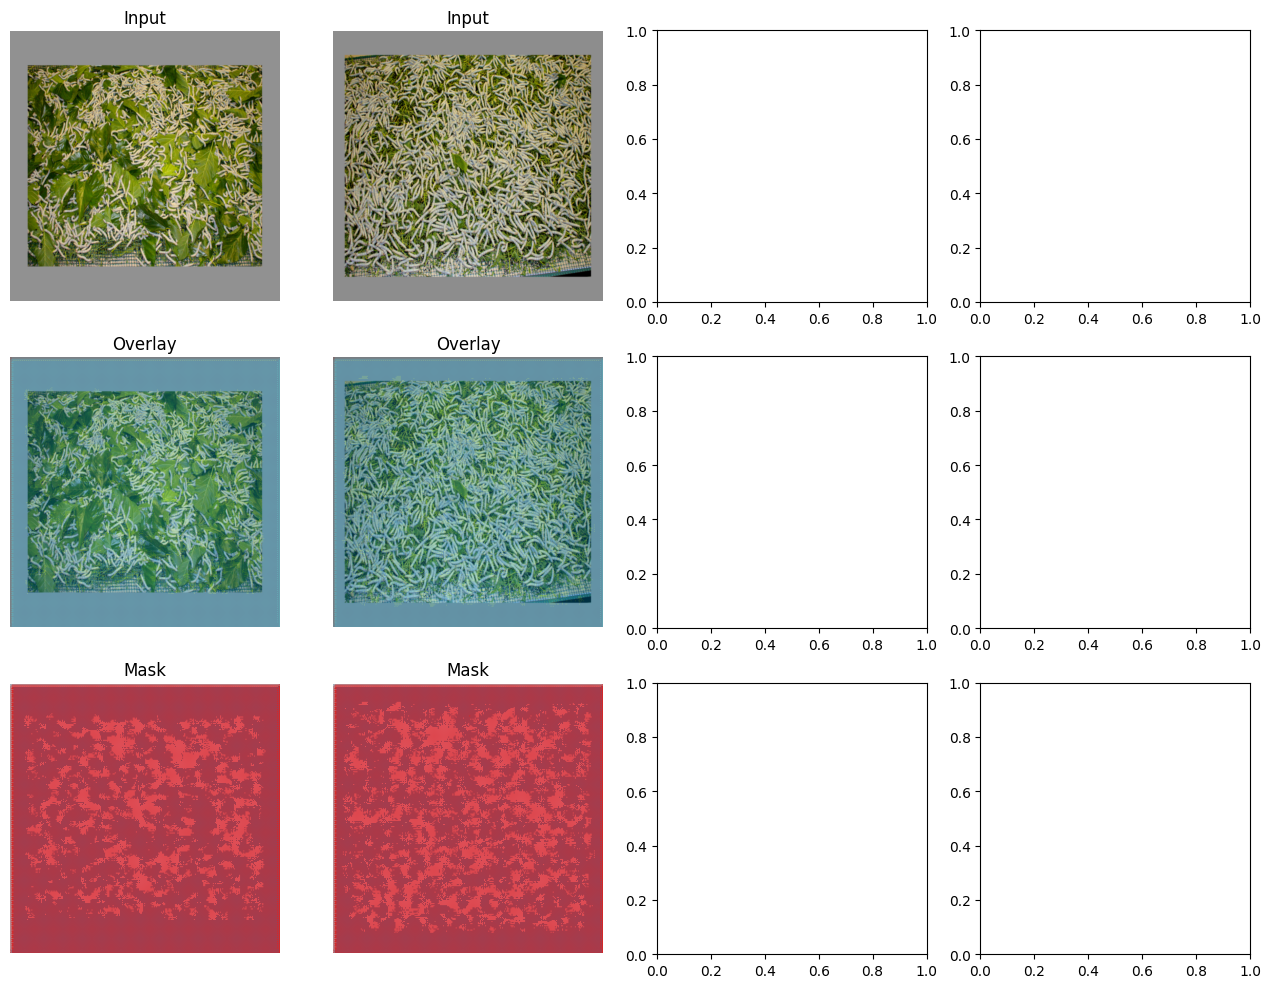

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn.functional as F

# Get a small batch
model.eval()
with torch.no_grad():
    imgs = next(iter(dataloader))[:4].to(DEVICE)                 # B×3×HxW
    logits = model(imgs)                                          # B×C×h×w (low-res output from ViT grid)
    masks = torch.argmax(logits, dim=1)                           # B×h×w (low-res masks)

# Un-normalize images for display
mean = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(3,1,1)
imgs_disp = (imgs * std + mean).clamp(0,1).cpu().permute(0,2,3,1).numpy()    # B×H×W×3

# Upsample masks to match input image resolution (nearest neighbor to preserve class labels)
target_H, target_W = imgs.shape[2], imgs.shape[3]
masks_upsampled = F.interpolate(
    masks.unsqueeze(1).float(),                    # B×1×h×w
    size=(target_H, target_W),
    mode='nearest'
).squeeze(1).cpu().numpy()                          # B×H×W (numpy)

# Plot
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i in range(4):
    # Row 1: Original Image
    axes[0,i].imshow(imgs_disp[i])
    axes[0,i].set_title("Input")
    axes[0,i].axis("off")
    
    # Row 2: Overlay
    axes[1,i].imshow(imgs_disp[i])
    axes[1,i].imshow(masks_upsampled[i], cmap="jet", alpha=0.3)   # Use upsampled mask
    axes[1,i].set_title("Overlay")
    axes[1,i].axis("off")
    
    # Row 3: Mask Only
    axes[2,i].imshow(masks_upsampled[i], cmap="tab20")            # Also use upsampled mask
    axes[2,i].set_title("Mask")
    axes[2,i].axis("off")

plt.tight_layout()
plt.show()
